<a href="https://colab.research.google.com/github/Javier1224/Reconocimiento_Leucemia/blob/main/Copia_de_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se cargan las librerías a utilizar durante el desarrollo del proyecto

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

import skimage
import skimage.color as skic # operaciones con color
from skimage.color import rgb2gray # Importar rgb2gray
import skimage.filters as skif # filtros
import skimage.util as sku # utilidades
import skimage.metrics as skm # métricas
from skimage import segmentation as seg # Segmentación
import skimage.io as skio

from skimage.exposure import histogram
from skimage.transform import resize
from skimage import img_as_float, exposure
from skimage.feature import hog
#from skimage.feature import greycomatrix, greycoprops
from skimage import color, data, transform
from skimage.feature import canny

  # Importar skimage.io para cargar la imagen
import matplotlib.image as mpimg
import cv2


# Para poder hacer la segmentacion
from sklearn.model_selection import train_test_split


Se recupera la información de la base de datos desde el repositorio

In [ ]:
!wget -q https://github.com/Javier1224/Reconocimiento_Leucemia/releases/download/Eliza/Datos.zip
!unzip -q Datos.zip

Se crean las funciones necesarias para manipular la información

In [ ]:
#Funcion para mostrar la imagen
def cargar_imagenes_por_carpeta(ruta):
  images = []
  imagen_con_Tag = []
  for filename in os.listdir(ruta):
      if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
          image_path = os.path.join(ruta, filename)
          image = skio.imread(image_path)


          # Extraer etiqueta desde el nombre de archivo (hasta el primer guión bajo por ejemplo)
          label = filename.split('-')[-2]
          imagen_con_Tag.append((image,label))
          #images.append(imagen_con_Tag)
  return imagen_con_Tag


def show(img):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray) # usar pyplot biultin colormap gray
    ax.set_axis_off()
    plt.show()

def show_images_side_by_side(images, names):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))

    for index, (img, name) in enumerate(zip(images, names)):
        axes[index].imshow(img, cmap=plt.cm.gray)
        axes[index].set_title(name)

    plt.show()

def linear_contrast_adjustment(image, min_intensity, max_intensity):
    # Ajusta el contraste linealmente
    adjusted_image = np.clip((image - min_intensity) * (255.0 / (max_intensity - min_intensity)), 0, 255)
    return adjusted_image.astype(np.uint8)

def showPair(image1, image2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image1, cmap='gray')
    ax1.axis('off')
    ax1.set_title('Imagen')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Imagen con bordes')
    plt.show()

def aplicar_espejo(imagen):
    return imagen.transpose(Image.FLIP_LEFT_RIGHT)

def crear_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

Funciones para realizar data augmentation

In [ ]:
# Simulación de augmentar_imagen para rotaciones y reflejos
def augmentar_imagen(imagen):
    transformacion = random.choice(['rot90', 'rot270', 'flip'])
    if transformacion == 'rot90':
        return np.rot90(imagen, k=1)
    elif transformacion == 'rot270':
        return np.rot90(imagen, k=3)
    elif transformacion == 'flip':
        return np.fliplr(imagen)
    return imagen  # En caso de fallo

# Función principal que separa y aumenta
def agrupar_etiquetas_malignas(label):
    if "Early" in label or "Pre" in label or "Pro" in label:
        return "Malignant"
    return "Benign"

# Función para separar en train/test y luego submuestrear
def procesar_con_submuestreo(carpetaRaiz):
  clases = ['Benign', 'Early', 'Pre', 'Pro']
  clases_malignas = ['Early', 'Pre', 'Pro']

  data_benign = carpetaRaiz[0]
  data_malign = carpetaRaiz[1] + carpetaRaiz[2] + carpetaRaiz[3]

  # Separar test y train por separado para cada grupo
  train_benign, test_benign = train_test_split(data_benign, test_size=0.2, random_state=42)
  train_malign, test_malign = train_test_split(data_malign, test_size=0.2, random_state=42)

  # Submuestreo: tomar el mínimo entre los dos
  min_train_samples = min(len(train_benign), len(train_malign))
  train_benign_sub = random.sample(train_benign, min_train_samples)
  train_malign_sub = random.sample(train_malign, min_train_samples)

  # Reconstruir estructura tipo carpetaRaiz
  datos_entrenamiento = [
      train_benign_sub,
      [img for img in train_malign_sub if "Early" in img[1]],
      [img for img in train_malign_sub if "Pro" in img[1]],
      [img for img in train_malign_sub if "Pre" in img[1]]
  ]

  datos_prueba = [
      test_benign,
      [img for img in test_malign if "Early" in img[1]],
      [img for img in test_malign if "Pro" in img[1]],
      [img for img in test_malign if "Pre" in img[1]]
  ]

  return datos_entrenamiento, datos_prueba

def agrupar_en_dos_clases(data_train):
    """
    Toma data_train con 4 listas (Benign, Early, Pro, Pre)
    y retorna una nueva lista con 2 listas:
    - [0]: lista de tuplas (imagen, 'Benign')
    - [1]: lista de tuplas (imagen, 'Malignant')
    """
    benignas = []
    malignas = []

    for i, clase in enumerate(data_train):
        for imagen, etiqueta in clase:
            if 'Benign' in etiqueta:
                benignas.append((imagen, 'Benign'))
            else:
                malignas.append((imagen, 'Malignant'))

    return [benignas, malignas]

def MostrarStructura(data):
  for i in range(len(data)):
    print(f"Categoría {data[i][0][1]} ahora tiene: {len(data[i])} imágenes")
  print(" ")

Ahora, se debe cargar las rutas desde las cuales cargar los datos a variables en python con las que poder trabajar

In [ ]:
# Se cargar cada carpeta de imagenes en una variable en particular
Benign = "/content/Original/Benign"
Early = "/content/Original/Early"
Pro = "/content/Original/Pre"
Pre = "/content/Original/Pro"

celulas = [Benign,Early,Pro,Pre]
celulasTag = ["Benign","Early","Pro","Pre"]
carpetaRaiz = []
for ruta in celulas:
  carpetaRaiz.append(cargar_imagenes_por_carpeta(ruta))

for folder in range(len(carpetaRaiz)):
  print(f'La cantidad de imagenes de {celulasTag[folder]} es {len(carpetaRaiz[folder])}')

La cantidad de imagenes de Benign es 504
La cantidad de imagenes de Early es 985
La cantidad de imagenes de Pro es 963
La cantidad de imagenes de Pre es 804


La estructura a manejar con los datos cargados es la siguiente:


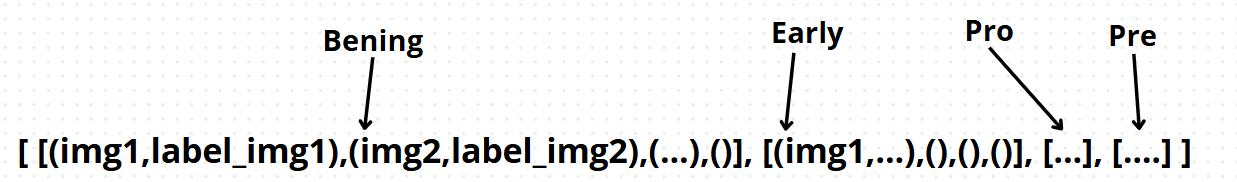

Se aplica el balanceo de carga en base a aplicar transformaciones de rotación de 90 grados y reflexión de las imágenes

In [ ]:
data_Train, data_Test = procesar_con_submuestreo(carpetaRaiz)

MostrarStructura(data_Train)
MostrarStructura(data_Test)
data_Train_1Etapa = agrupar_en_dos_clases(data_Train)
MostrarStructura(data_Train_1Etapa)
data_Test_1Etapa = agrupar_en_dos_clases(data_Test)
MostrarStructura(data_Test_1Etapa)

Categoría Benign ahora tiene: 403 imágenes
Categoría Early ahora tiene: 140 imágenes
Categoría Pro ahora tiene: 117 imágenes
Categoría Pre ahora tiene: 146 imágenes
 
Categoría Benign ahora tiene: 101 imágenes
Categoría Early ahora tiene: 203 imágenes
Categoría Pro ahora tiene: 161 imágenes
Categoría Pre ahora tiene: 187 imágenes
 
Categoría Benign ahora tiene: 403 imágenes
Categoría Malignant ahora tiene: 403 imágenes
 
Categoría Benign ahora tiene: 101 imágenes
Categoría Malignant ahora tiene: 551 imágenes
 


Se define la función que hará el procesamiento de la información para una entrada de datos determinada.

In [ ]:
def preprocesar_imagenes(data,SHOW):
  Preprocesada = []
  for folder in range(len(data)):
      images = data[folder]
      images_preprocesadas = []
      cant_muestras_sh = 0

      for i in range(len(images)):
          # Entrada
          img_rgb = images[i][0]
          label_img = images[i][1]

          # Convertir a HSV
          img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

          # Segmentación por umbral HSV
          lower = np.array([120, 70, 70])
          upper = np.array([180, 255, 255])
          mask = cv2.inRange(img_hsv, lower, upper)
          segmented = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)

          # Convertir a RGB para modelos preentrenados que esperan RGB
          segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_HSV2RGB)

          # Redimensionar a 224x224
          resized = cv2.resize(segmented_rgb, (224, 224), interpolation=cv2.INTER_AREA)

          # Normalización [0,1]
          normalized = resized.astype(np.float32) / 255.0

          # Agregar imagen con su etiqueta
          images_preprocesadas.append((normalized, label_img))

          # Visualizar solo las dos primeras por clase
          if SHOW == True:
            if cant_muestras_sh < 4:
                fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))
                axs[0].imshow(img_rgb)
                axs[0].set_title(label_img)
                axs[1].imshow(img_hsv)
                axs[1].set_title("HSV")
                axs[2].imshow(mask, cmap='gray')
                axs[2].set_title("Máscara binaria")
                axs[3].imshow(resized)
                axs[3].set_title("Segmentado y Redimensionado")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            cant_muestras_sh += 1

      Preprocesada.append(tuple(images_preprocesadas))
  return Preprocesada

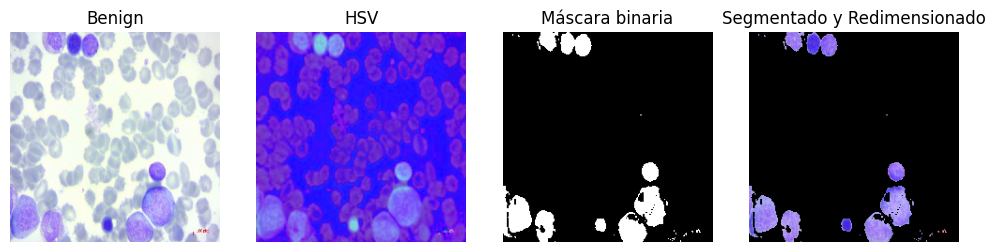

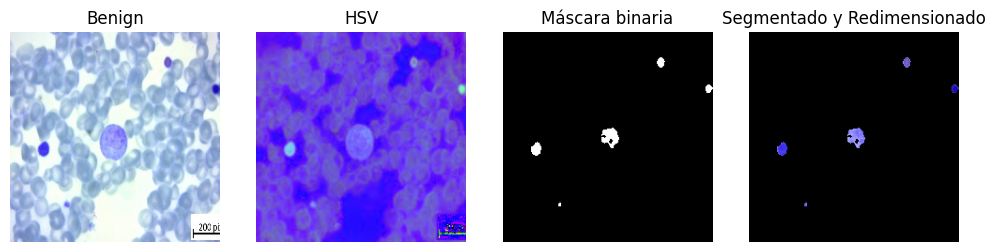

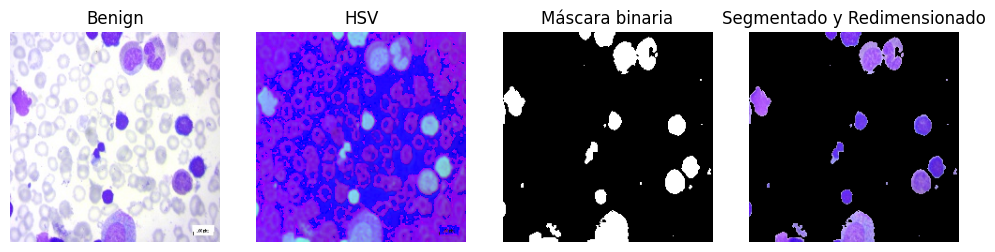

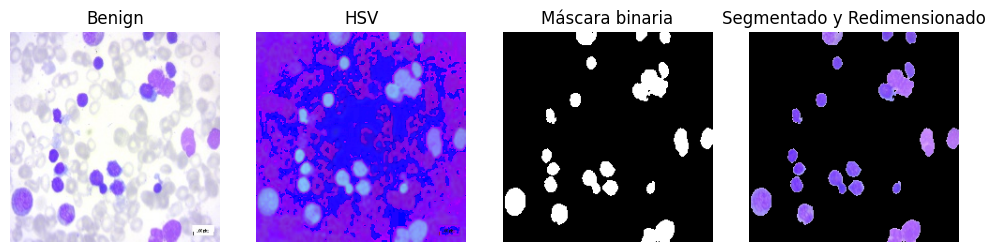

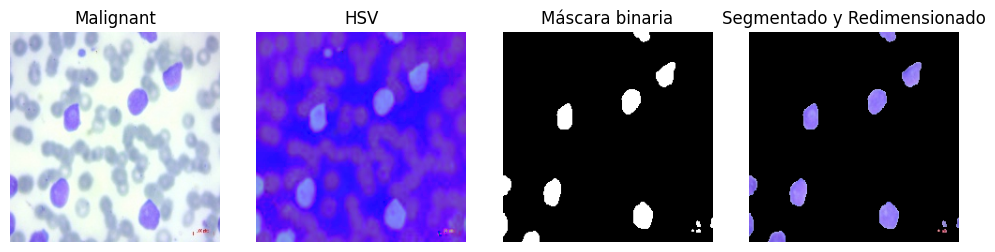

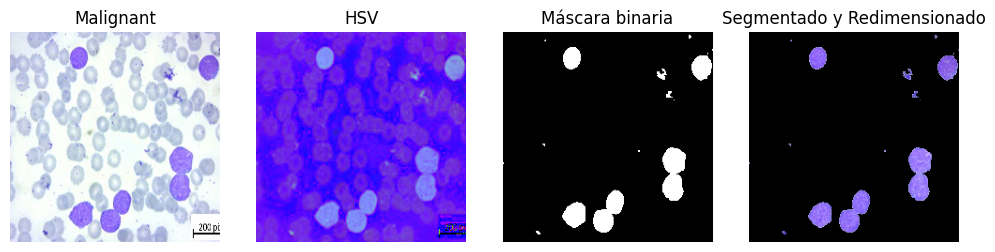

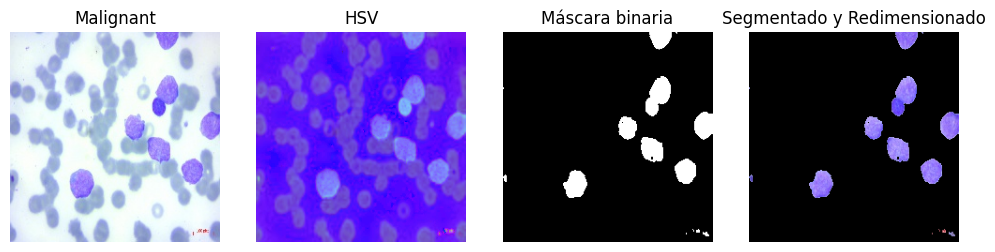

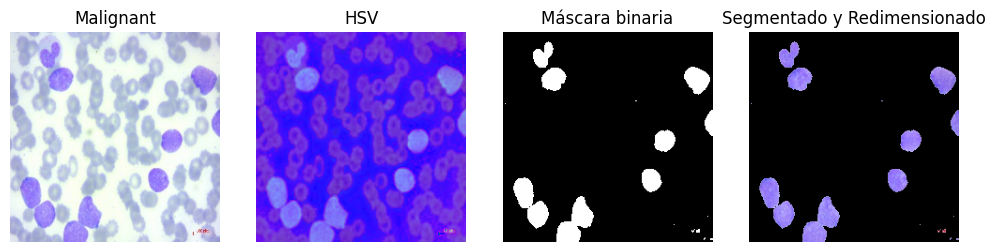

In [ ]:
DataTrain_Preprocesada = preprocesar_imagenes(data_Train_1Etapa,True)
DataTest_Preprocesada = preprocesar_imagenes(data_Test_1Etapa,False)
Data_TrainPreMaligna =  preprocesar_imagenes(data_Train,False)
Data_TestPreMaligna =  preprocesar_imagenes(data_Test,False)

## Entrenamiento del modelo

Librerías necesarias para el modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, AUC, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Con estas funciones se extraen y separan los datos necesarios para entrenar y probar el modelo en dos etapas, una función separa del data set entre benigno y maligno y la otra solo toma las muestras con etiqueta Early, Pro y Pre

In [ ]:
def preparar_datos_para_modelo(data_preprocesada, mapa_etiquetas=None):
    imagenes = []
    etiquetas = []
    tamaño=(224, 224)

    for clase in data_preprocesada:
        for imagen, etiqueta in clase:
            # Redimensionar imagen
            imagen_resized = tf.image.resize(imagen, tamaño)
            imagenes.append(imagen_resized.numpy())  # Convertir a array NumPy
            etiquetas.append(etiqueta)

    imagenes = np.array(imagenes)

    # Crear mapa de etiquetas si no se proporciona
    if mapa_etiquetas is None:
        etiquetas_unicas = sorted(set(etiquetas))
        mapa_etiquetas = {nombre: idx for idx, nombre in enumerate(etiquetas_unicas)}

    # Convertir etiquetas a valores binarios
    etiquetas_num = np.array([mapa_etiquetas[et] for et in etiquetas])
    if len(mapa_etiquetas) > 2:
        etiquetas_num = to_categorical(etiquetas_num, num_classes=len(mapa_etiquetas))
    return imagenes, etiquetas_num, mapa_etiquetas

In [ ]:
imagenes_train, etiquetas_train, mapa_etiquetas = preparar_datos_para_modelo(DataTrain_Preprocesada)
imagenes_test, etiquetas_test, _ = preparar_datos_para_modelo(DataTest_Preprocesada, mapa_etiquetas)
imagenes_train2E, etiquetas_train2E, mapa_etiquetas2E = preparar_datos_para_modelo(Data_TrainPreMaligna[1:])
imagenes_test2E, etiquetas_test2E, _ = preparar_datos_para_modelo(Data_TestPreMaligna[1:], mapa_etiquetas2E)

In [ ]:
def graficar_metricas(historia):
    metricas = ['accuracy', 'loss', 'precision', 'recall', 'auc', 'top_k_categorical_accuracy']

    for metrica in metricas:
        if metrica in historia.history:
            plt.figure(figsize=(6, 4))
            plt.plot(historia.history[metrica], label=f'Train {metrica}')
            plt.plot(historia.history['val_' + metrica], label=f'Val {metrica}')
            plt.xlabel('Epochs')
            plt.ylabel(metrica)
            plt.title(f'Evolución de {metrica}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

Primera etapa

In [ ]:
# Cargar base de ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#  Congelar solo las capas inferiores (por ejemplo, 140 de 175)
for layer in base_model.layers[:140]:
    layer.trainable = False
for layer in base_model.layers[140:]:
    layer.trainable = True

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout para regularización
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Para binario

modelo = Model(inputs=base_model.input, outputs=output)

# Compilar modelo
modelo.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.6148 - auc_6: 0.6360 - loss: 0.6690 - precision_6: 0.6219 - recall_6: 0.5091 - val_accuracy: 0.7209 - val_auc_6: 0.6390 - val_loss: 0.6668 - val_precision_6: 0.8742 - val_recall_6: 0.7822
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.7098 - auc_6: 0.8144 - loss: 0.5226 - precision_6: 0.6809 - recall_6: 0.8023 - val_accuracy: 0.8482 - val_auc_6: 0.7575 - val_loss: 0.5183 - val_precision_6: 0.8488 - val_recall_6: 0.9982
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 235s 5s/step - accuracy: 0.7857 - auc_6: 0.8761 - loss: 0.4413 - precision_6: 0.7864 - recall_6: 0.7667 - val_accuracy: 0.8574 - val_auc_6: 0.8275 - val_loss: 0.3983 - val_precision_6: 0.8601 - val_recall_6: 0.9927
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.8364 - auc_6: 0.9192 - loss: 0.3608 - precision_6: 0.8193 - recall_6: 0.8656 - val_accuracy: 0.6779 - val_auc_6: 0.8655 - val_loss: 0.5194 - val_precision_6: 0.9671 - val_recal

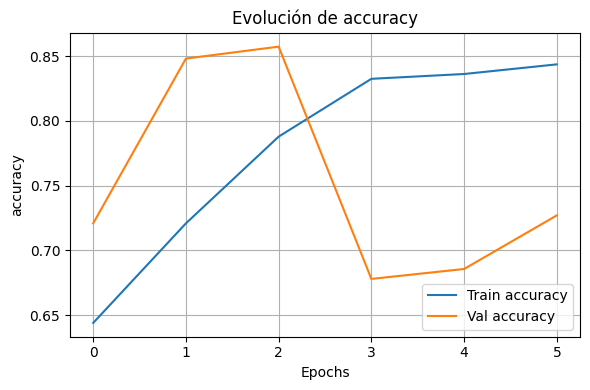

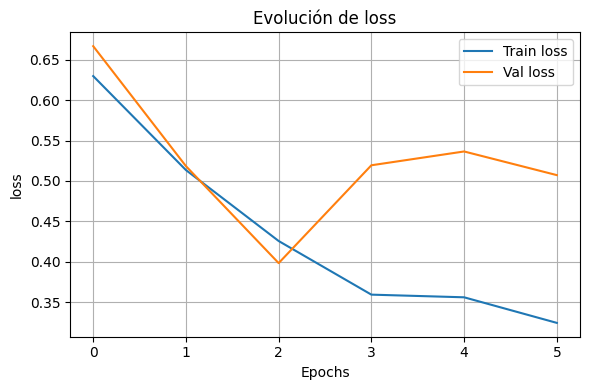

In [ ]:
# Entrenar modelo
historia = modelo.fit(
    imagenes_train,
    etiquetas_train,
    validation_data=(imagenes_test, etiquetas_test),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)

# Graficar histórico del modelo
graficar_metricas(historia)

Segunda etapa

In [ ]:
# 1. Cargar el modelo base desde cero para multiclase
base_model2E = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# 2. Congelar las capas que no quieres entrenar
for layer in base_model2E.layers[:140]:
    layer.trainable = False
for layer in base_model2E.layers[140:]:
    layer.trainable = True

# 3. Agregar las capas superiores nuevas
x = base_model2E.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)  # ← ahora salida de 3 clases con función de activación softmax

modelo2E = Model(inputs=base_model2E.input, outputs=output)

# 4. Compilar con categorical_crossentropy y métricas multiclase
modelo2E.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# 5. Early stopping (lo puedes dejar igual)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step - accuracy: 0.6158 - auc: 0.8104 - loss: 0.7995 - precision: 0.7000 - recall: 0.5155 - val_accuracy: 0.4102 - val_auc: 0.7286 - val_loss: 1.0870 - val_precision: 0.4125 - val_recall: 0.3848
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.8854 - auc: 0.9697 - loss: 0.3361 - precision: 0.8925 - recall: 0.8543 - val_accuracy: 0.4047 - val_auc: 0.7422 - val_loss: 1.0227 - val_precision: 0.4066 - val_recall: 0.3829
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.8831 - auc: 0.9762 - loss: 0.2877 - precision: 0.8873 - recall: 0.8791 - val_accuracy: 0.4483 - val_auc: 0.6615 - val_loss: 1.1428 - val_precision: 0.4584 - val_recall: 0.4301
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8788 - auc: 0.9743 - loss: 0.3041 - precision: 0.8818 - recall: 0.8723 - val_accuracy: 0.2686 - val_auc: 0.5542 - val_loss: 1.2615 - val_precision: 0.2929 - val_recall: 0.2541
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━

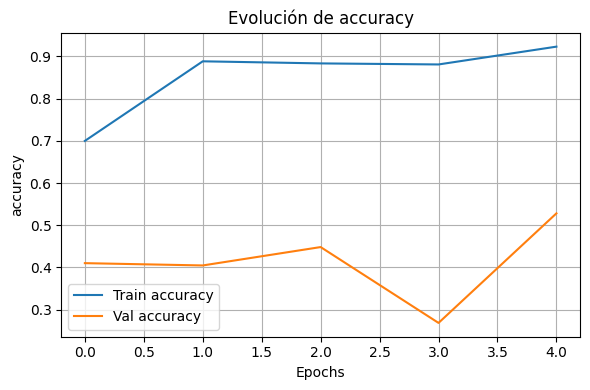

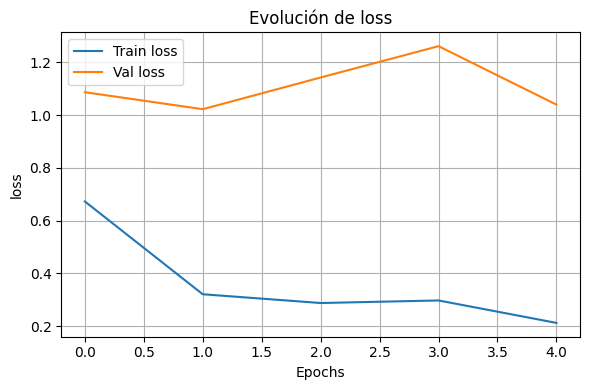

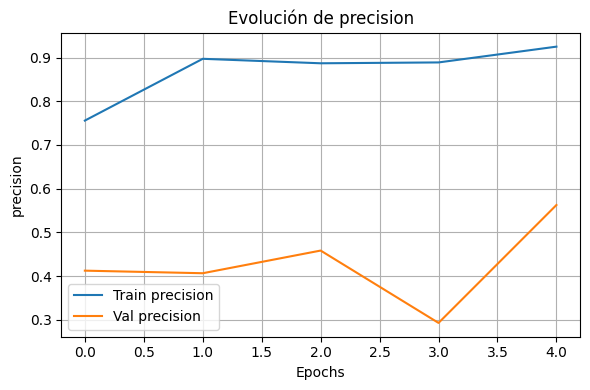

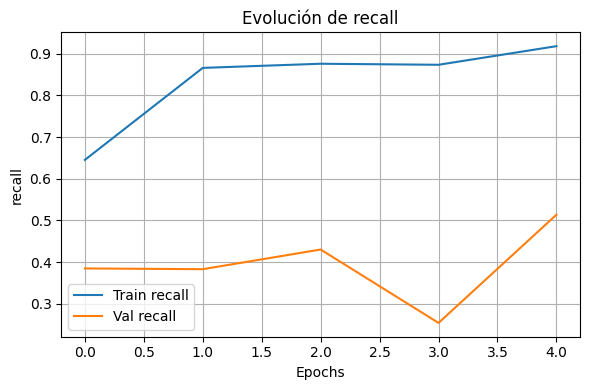

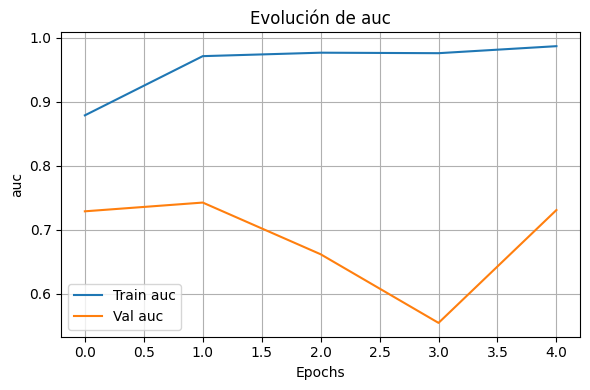

In [ ]:
# 6. Entrenar
historia2E = modelo2E.fit(
    imagenes_train2E,
    etiquetas_train2E,  # ← deben estar en formato one-hot
    validation_data=(imagenes_test2E, etiquetas_test2E),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)
graficar_metricas(historia2E)

26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step


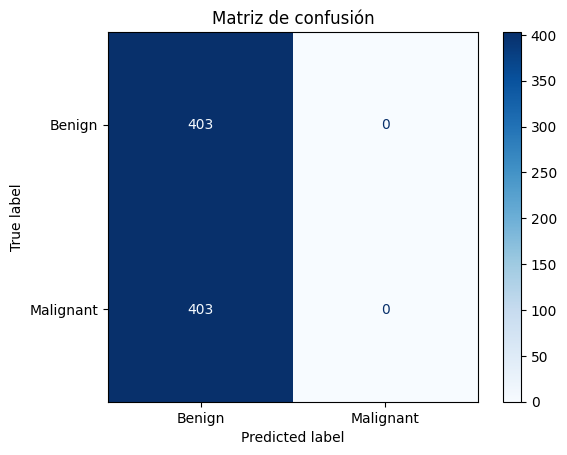

21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step


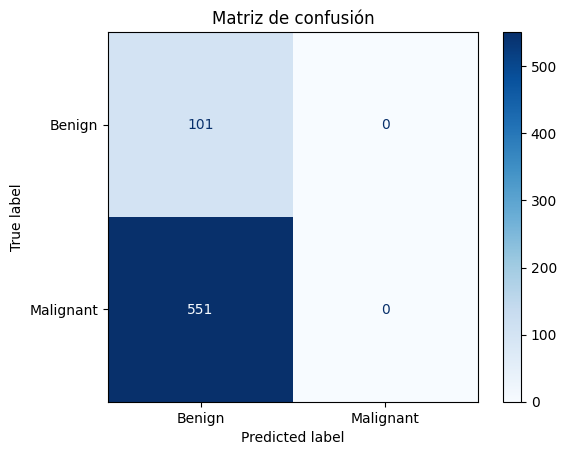

13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
def predecir_y_mostrar_matriz_confusion(modelo, imagenes_test, etiquetas_test, mapa_etiquetas):
  # 1. Obtener predicciones del modelo
  predicciones = modelo.predict(imagenes_test)  # salidas con softmax

  # 2. Convertir predicciones a clases (índice con probabilidad más alta)
  pred_clases = np.argmax(predicciones, axis=1)

  # 3. Asegurar que etiquetas verdaderas estén en formato entero (no one-hot)
  # etiquetas_test2E ya debe ser un vector de enteros (como [0,1,2,...])
  # Si está en one-hot, conviértelo:
  # etiquetas_verdaderas = np.argmax(etiquetas_test2E, axis=1)
  etiquetas_verdaderas = etiquetas_test

  # 4. Crear matriz de confusión
  cm = confusion_matrix(etiquetas_verdaderas, pred_clases)

  # 5. Mostrarla con etiquetas
  etiquetas_nombres = list(mapa_etiquetas.keys())  # etiquetas reales como ['Early', 'Pre', 'Pro']
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas_nombres)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de confusión")
  plt.show()


predecir_y_mostrar_matriz_confusion(modelo, imagenes_train, etiquetas_train, mapa_etiquetas)
predecir_y_mostrar_matriz_confusion(modelo, imagenes_test, etiquetas_test, mapa_etiquetas)
predecir_y_mostrar_matriz_confusion(modelo2E, imagenes_train2E, etiquetas_train2E, mapa_etiquetas2E)
predecir_y_mostrar_matriz_confusion(modelo2E, imagenes_test2E, etiquetas_test2E, mapa_etiquetas2E)

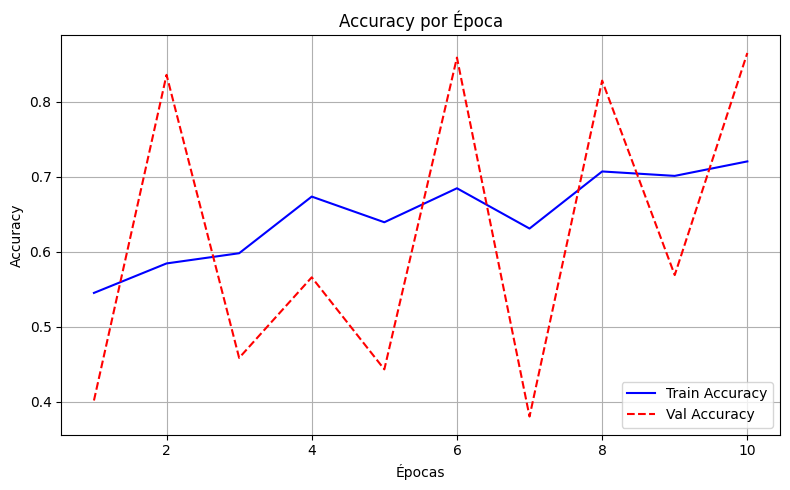

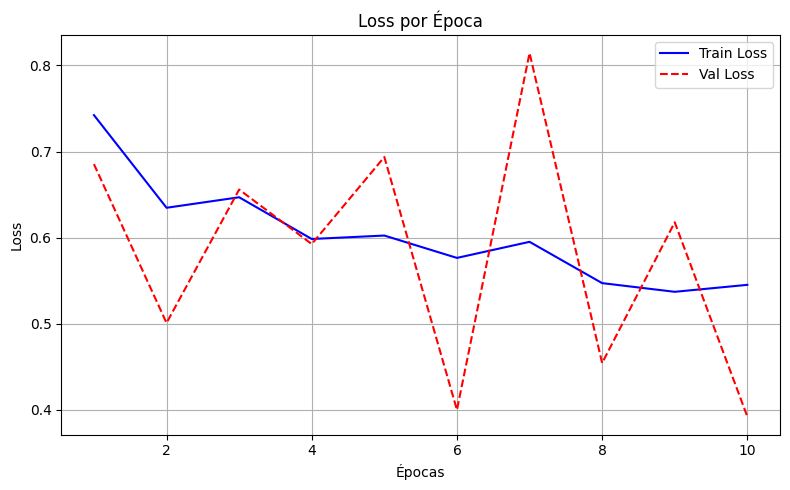

In [ ]:
def graficar_metricas(train, val, nombre_metrica):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train, 'b-', label=f'Train {nombre_metrica}')
    plt.plot(epochs, val, 'r--', label=f'Val {nombre_metrica}')
    plt.title(f'{nombre_metrica} por Época')
    plt.xlabel('Épocas')
    plt.ylabel(nombre_metrica)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

accuracy = [0.5452, 0.5845, 0.5981, 0.6736, 0.6394, 0.6847, 0.6310, 0.7071, 0.7012, 0.7205]
val_accuracy = [0.4018, 0.8359, 0.4586, 0.5660, 0.4433, 0.8589, 0.3804, 0.8282, 0.5690, 0.8650]

loss = [0.7423, 0.6346, 0.6468, 0.5983, 0.6023, 0.5763, 0.5950, 0.5470, 0.5369, 0.5450]
val_loss = [0.6853, 0.5007, 0.6558, 0.5924, 0.6936, 0.3996, 0.8145, 0.4541, 0.6177, 0.3919]

auc = [0.5540, 0.6442, 0.6627, 0.7342, 0.7144, 0.7608, 0.7175, 0.7986, 0.7900, 0.7921]
val_auc = [0.5205, 0.8945, 0.5622, 0.6566, 0.5326, 0.9165, 0.4857, 0.9046, 0.6554, 0.9248]

precision = [0.5452, 0.5845, 0.5981, 0.6736, 0.6394, 0.6847, 0.6310, 0.7071, 0.7012, 0.7205]
val_precision = [0.4018, 0.8359, 0.4586, 0.5660, 0.4433, 0.8589, 0.3804, 0.8282, 0.5690, 0.8650]

recall = [0.5452, 0.5845, 0.5981, 0.6736, 0.6394, 0.6847, 0.6310, 0.7071, 0.7012, 0.7205]
val_recall = [0.4018, 0.8359, 0.4586, 0.5660, 0.4433, 0.8589, 0.3804, 0.8282, 0.5690, 0.8650]

graficar_metricas(accuracy, val_accuracy, 'Accuracy')
graficar_metricas(loss, val_loss, 'Loss')

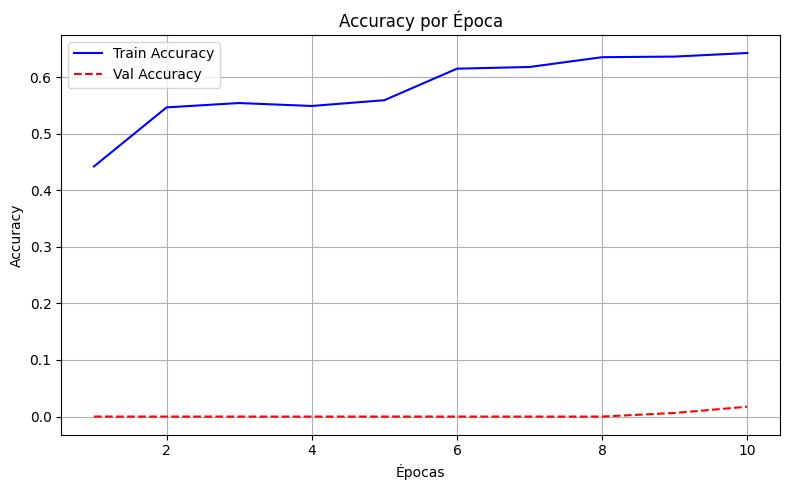

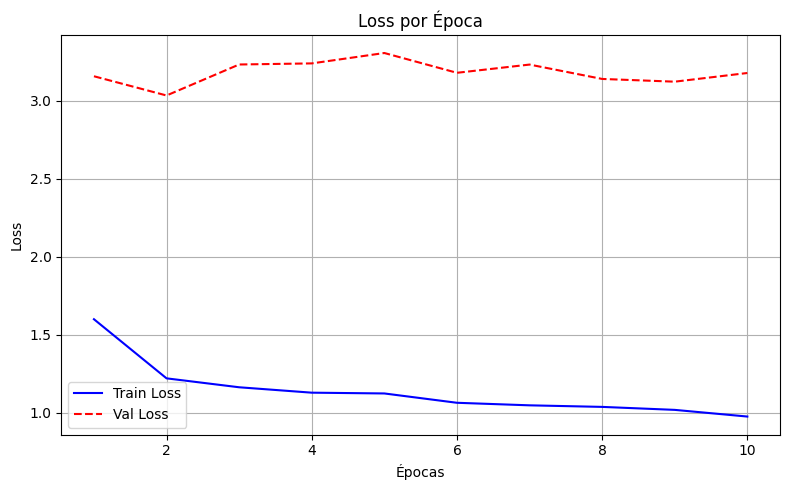

In [ ]:
epocas = list(range(1, 11))  # Epochs del 1 al 10

accuracy =     [0.4419, 0.5463, 0.5540, 0.5488, 0.5590, 0.6147, 0.6177, 0.6350, 0.6361, 0.6424]
loss =         [1.6001, 1.2216, 1.1645, 1.1299, 1.1249, 1.0652, 1.0489, 1.0389, 1.0198, 0.9771]
val_accuracy = [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0063, 0.0174]
val_loss =     [3.1554, 3.0323, 3.2307, 3.2377, 3.3042, 3.1775, 3.2302, 3.1382, 3.1207, 3.1762]


graficar_metricas(accuracy, val_accuracy, 'Accuracy')
graficar_metricas(loss, val_loss, 'Loss')